In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import IPython.display as ipd
import sys
import os
import torch
import torch.onnx
from torch.nn import functional as F
import numpy as np
from tqdm.notebook import tqdm
import re
import time
sys.path.insert(0, "../")
from models.encodec.onnx.streaming import Encodec
from utils import get_hparams
from models import get_wrapper
import librosa


base_dir = "../logs/encodec24khz/hil_speech"

hps = get_hparams(None, base_dir)
# hps.model_kwargs.update(dict(
#     kernel_size=3,
#     last_kernel_size=3,
#     residual_kernel_size=3
# ))
hps.model_kwargs.pop("spec_learnable")
hps.model_kwargs.pop("causal")
hps.model_kwargs.pop("pad_mode")
size = "small" if hps.model_kwargs.channels_dec == 32 else "big"
model = Encodec(16_000, **hps.model_kwargs)
model.eval()

wrapper = get_wrapper(hps.model)(hps, train=False)
wrapper.load()
wrapper.eval()
SR = model.sample_rate

Loading checkpoint file '../logs/encodec24khz/hil_speech/00150.pth'...


In [2]:
self, encoder = model.encoder, wrapper.model.encoder
self.conv_pre.load_state_dict(encoder.conv_pre[1].conv.conv.state_dict())
for self_resblocks, resblocks in zip(self.blocks, encoder.blocks):
    for self_resblock, resblock in zip(self_resblocks, resblocks):
        self_resblock.block[0].pointwise[1].load_state_dict(resblock.block[1].conv.conv.state_dict())
        self_resblock.block[0].depthwise.load_state_dict(resblock.block[2].conv.conv.state_dict())
        self_resblock.block[1].pointwise[1].load_state_dict(resblock.block[4].conv.conv.state_dict())
        self_resblock.block[1].depthwise.load_state_dict(resblock.block[5].conv.conv.state_dict())
        self_resblock.res_scale_param.data.copy_(resblock.res_scale_param.data)
    for self_specblock, specblock in zip(self.spec_blocks, encoder.spec_blocks):
        self_specblock.layer.load_state_dict(specblock.layer.conv.conv.state_dict())
        self_specblock.scale_param.data.copy_(specblock.scale_param.data)
    for self_downp, self_downd, down in zip(self.downsample_pointwise, self.downsample_depthwise, encoder.downsample):
        self_downp[1].load_state_dict(down[2].conv.conv.state_dict())
        self_downd.load_state_dict(down[3].conv.conv.state_dict())
self.spec_post.layer.load_state_dict(encoder.spec_post.layer.conv.conv.state_dict())
self.spec_post.scale_param.data.copy_(encoder.spec_post.scale_param.data)
self.conv_post_depthwise.load_state_dict(encoder.conv_post[1].conv.conv.state_dict())
self.conv_post_pointwise.load_state_dict(encoder.conv_post[2].conv.conv.state_dict())

self, decoder = model.decoder, wrapper.model.decoder.model
self.conv_pre_pointwise.load_state_dict(decoder[0].conv.conv.state_dict())
self.conv_pre_depthwise.load_state_dict(decoder[1].conv.conv.state_dict())
idx = 2
for up_depth, up_point, resblocks in zip(self.upsample_depthwise, self.upsample_pointwise, self.blocks):
    idx += 2    # scale & upsample_act
    up_depth.load_state_dict(decoder[idx].convtr.convtr.state_dict()); idx += 1
    up_point.load_state_dict(decoder[idx].conv.conv.state_dict()); idx += 1
    for resblock in resblocks:
        resblock.block[0].pointwise[1].load_state_dict(decoder[idx].block[1].conv.conv.state_dict())
        resblock.block[0].depthwise.load_state_dict(decoder[idx].block[2].conv.conv.state_dict())
        resblock.block[1].pointwise[1].load_state_dict(decoder[idx].block[4].conv.conv.state_dict())
        resblock.block[1].depthwise.load_state_dict(decoder[idx].block[5].conv.conv.state_dict())
        resblock.res_scale_param.data.copy_(decoder[idx].res_scale_param.data)
        idx += 1  # end of each resblock
idx += 2    # scale & upsample_act
self.conv_post.load_state_dict(decoder[idx].conv.conv.state_dict())

for vq1, vq2, vq3 in zip(model.quantizer.layers, model.dequantizer.layers, wrapper.model.quantizer.layers):
    vq1.embed.data.copy_(vq3.embed.data)
    vq1.ema_num.data.copy_(vq3.ema_num.data)
    vq2.embed.data.copy_(vq3.embed.data)
    vq2.ema_num.data.copy_(vq3.ema_num.data)

model.eval()
model.remove_weight_reparameterizations()
print("loaded!")

loaded!


In [3]:
cache_enc, cache_dec = model.initialize_cache(torch.randn(1))

torch.set_num_threads(1)
hop_size = 320

wav, _ = librosa.core.load("/home/shahn/Datasets/VCTK-0.92/wav16_silence_trimmed/p225/p225_003_mic1.wav", sr=SR)
# wav = np.concatenate((wav, wav, wav, wav))
wav = torch.from_numpy(wav).view(1,1,  -1)
length = wav.size(-1) // hop_size * hop_size
wav = wav[:,:,:length]
wav_in = wav[:, :, :hop_size]
print("cache initialized!")

cache initialized!


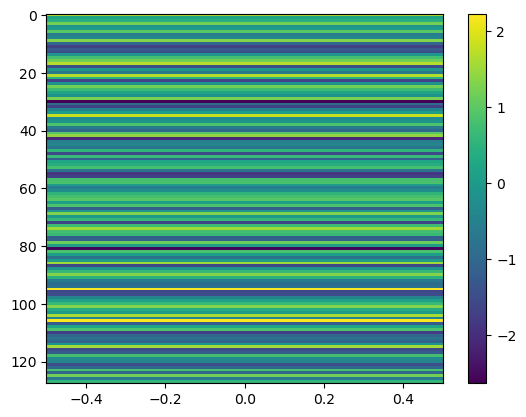

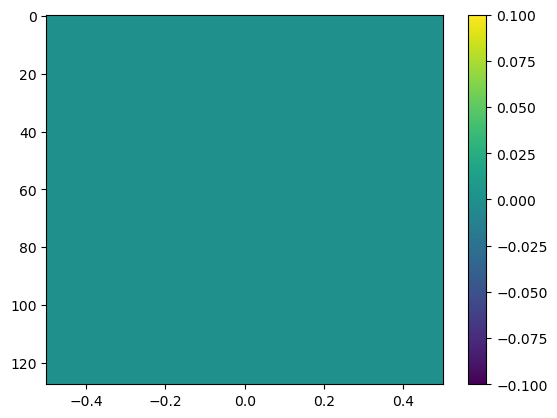

In [6]:
def plot_diff(y1, y2):
    im=plt.imshow(y1.squeeze(0), interpolation='nearest', aspect='auto')
    plt.colorbar(im)
    plt.show()
    im=plt.imshow(((y1-y2)).squeeze(0), interpolation='nearest', aspect='auto')
    plt.colorbar(im)
    plt.show()

x = torch.randn(1, 1, 320)
wav = torch.cat((cache_enc[0], x), dim=2)
with torch.no_grad():
    # ENCODER
    self = model.encoder
    wav_cache_len = self.spec_post.spec.cache_len
    y1 = model.encoder.conv_pre(wav[:, :, wav_cache_len-self.conv_pre_cache_len:])
    y2 = wrapper.model.encoder.conv_pre(x)
    idx = 1
    for blocks, spec_block, down_pointwise, down_depthwise in zip(
        self.blocks, self.spec_blocks, self.downsample_pointwise, self.downsample_depthwise
    ):
        _wav = wav[:, :, wav_cache_len-spec_block.spec.cache_len:]
        y1 = spec_block(y1, _wav)
        for block in blocks:
            n = len(block.block)
            y1, cache = block(y1, cache_enc[idx:idx + n])
            idx += n
        y1 = self.scale_layer(y1)
        y1 = down_pointwise(y1)
        y1, cache = down_depthwise(y1, cache_enc[idx])
        idx += 1
    y1 = self.spec_post(y1, wav)
    y1 = self.conv_post_act(y1)
    y1, cache = self.conv_post_depthwise(y1, cache_enc[idx])
    y1 = self.conv_post_pointwise(y1)
    y1 = self.l2norm(y1)
    y1 = model.quantizer(y1.transpose(1, 2), 8)
    y1 = model.dequantizer(y1, 8).transpose(1, 2)
    
    # DECODER
#     self = model.decoder
#     y1 = self.conv_pre_pointwise(y1)
#     y1, cache = self.conv_pre_depthwise(y1, cache_dec[0])
#     idx = 1
#     for blocks, up_act, up_depthwise, up_pointwise in zip(
#         self.blocks, self.upsample_act, self.upsample_depthwise, self.upsample_pointwise
#     ):
#         x = up_act(x)
#         x, cache = up_depthwise(x, cache_dec[idx])
#         x = up_pointwise(x)
#         idx += 1
#         for block in blocks:
#             block: ResBlock
#             n = len(block.block)
#             x, cache = block(x, cache_in[idx:idx + n])
#             idx += n
#         x = self.scale_layer(x)
    
    # ENCODER
    self = wrapper.model.encoder
    for block, spec_block, downsample in zip(self.blocks, self.spec_blocks, self.downsample):
        y2 = spec_block(y2, x)
        y2 = block(y2)
        y2 = downsample(y2)
    y2 = self.spec_post(y2, x)
    y2 = self.conv_post(y2)
    y2, *_ = wrapper.model.quantizer(y2, 8)
#     self= wrapper.model.decoder
#     y2 = self.model[0](y2)
#     y2 = self.model[1](y2)
#     idx = 2
#     for i, ratio in enumerate(self.ratios):
#         y2 = self.model[idx]    # scale
#         y2 = self.model[idx+1] # act
plot_diff(y1, y2)

  0%|          | 0/379 [00:00<?, ?it/s]

enc_time: 3.6 sec / rtf: 2.086819958504107 (↑)
dec_time: 10.2 sec / rtf: 0.7436670734264746 (↑)
total: 13.8 sec / rtf: 0.5482799510479323 (↑)


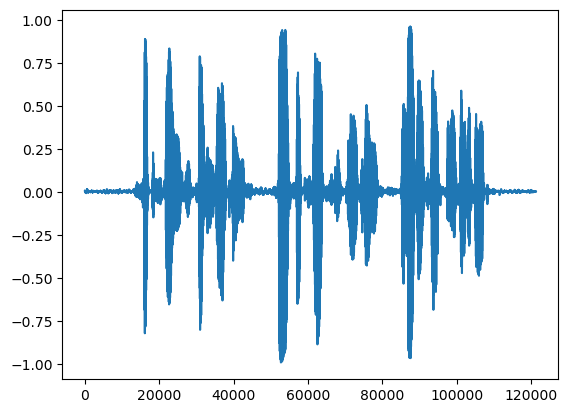

In [7]:
wav_out_list = []
enc_time, dec_time = 0., 0.
indices_list = []
with torch.no_grad():
    st = time.perf_counter()
    for i in tqdm(range(0, length, hop_size)):
        wav_in = wav[:, :, i:i+hop_size]
        x, cache_enc = model.encoder(wav_in, *cache_enc)
        indices = model.quantizer(x, 8)
        indices_list.append(indices)
    et = time.perf_counter()
    enc_time += et - st
    st = et
    for indices in tqdm(indices_list):
        q = model.dequantizer(indices, 8)
        wav_out, cache_dec = model.decoder(q, *cache_dec)
        wav_out_list.append(wav_out.squeeze(1))
    et = time.perf_counter()
    dec_time += et - st
    st = et

print(f"enc_time: {enc_time:.1f} sec / rtf: {length/SR / enc_time} (↑)")
print(f"dec_time: {dec_time:.1f} sec / rtf: {length/SR / dec_time} (↑)")
total = enc_time + dec_time
print(f"total: {total:.1f} sec / rtf: {length/SR / total} (↑)")

wav_out = torch.cat(wav_out_list, dim=1)
plt.plot(wav_out[0].numpy())
plt.show()
ipd.display(ipd.Audio(wav_out[0].numpy(), rate=SR, normalize=False))
ipd.display(ipd.Audio(wav.numpy().squeeze(), rate=SR, normalize=False))
cache_enc, cache_dec = model.initialize_cache(torch.randn(1))

# Import each

In [5]:
cache_enc, cache_dec = model.initialize_cache(torch.randn(1))
NAME = "hil_speech_onnxstft"
### Encoder ###
dynamic_axes = dict(wav_in={0: 'batch', 2: 'time'})
dynamic_axes.update({f"e_in{i}": {0: "batch", 2:"time"} for i in range(len(cache_enc))})
dynamic_axes.update({f"e_out{i}": {0: "batch", 2:"time"} for i in range(len(cache_enc))})
torch.onnx.export(
    model.encoder,
    (wav_in, *cache_enc),
    f"encodec_onnx/{NAME}_enc.onnx",
    input_names = ['wav_in'] + [f'e_in{i}' for i in range(len(cache_enc))],
    output_names = ['x'] + [f'e_out{i}' for i in range(len(cache_enc))],
    dynamic_axes = dynamic_axes,
    opset_version=17
)
cache_enc_dict = {f"e_in{i}": e.numpy() for i, e in enumerate(cache_enc)}
np.savez(f'encodec_onnx/{NAME}_cache_enc.npz', **cache_enc_dict)

### Quantizer ###
for idx, vq in enumerate(model.quantizer.layers):
    torch.onnx.export(
        vq,
        (x,),
        f"encodec_onnx/{NAME}_vq{idx}.onnx",
        input_names = ['x'],
        output_names = ['q', 'idx'],
        dynamic_axes={"x": {0: "batch", 1: "time"}}
    )

### Dequantizer ###
for idx, deq in enumerate(model.dequantizer.layers):
    torch.onnx.export(
        deq,
        (indices[0],),
        f"encodec_onnx/{NAME}_deq{idx}.onnx",
        input_names = ['idx'],
        output_names = ['q'],
        dynamic_axes={"idx": {0: "batch", 1: "time"}}
    )

### Decoder ###
dynamic_axes = dict(q={0: 'batch', 1: 'time'})
dynamic_axes.update({f"d_in{i}": {0: "batch", 2:"time"} for i in range(len(cache_dec))})
dynamic_axes.update({f"d_out{i}": {0: "batch", 2:"time"} for i in range(len(cache_dec))})
torch.onnx.export(
    model.decoder,
    (x, *cache_dec),
    f"encodec_onnx/{NAME}_dec.onnx",
    input_names = ['q'] + [f'd_in{i}' for i in range(len(cache_dec))],
    output_names = ['wav_out'] + [f'd_out{i}' for i in range(len(cache_dec))],
    dynamic_axes = dynamic_axes
)
cache_dec_dict = {f"d_in{i}": e.numpy() for i, e in enumerate(cache_dec)}
np.savez(f'encodec_onnx/{NAME}_cache_dec.npz', **cache_dec_dict)
print("onnx ported!")

/home/shahn/miniconda3/envs/torch1.13/lib/python3.10/site-packages/torch/onnx/_internal/jit_utils.py:258: UserWarning: The shape inference of prim::Constant type is missing, so it may result in wrong shape inference for the exported graph. Please consider adding it in symbolic function. (Triggered internally at /opt/conda/conda-bld/pytorch_1666642969563/work/torch/csrc/jit/passes/onnx/shape_type_inference.cpp:1884.)
  _C._jit_pass_onnx_node_shape_type_inference(node, params_dict, opset_version)
/home/shahn/miniconda3/envs/torch1.13/lib/python3.10/site-packages/torch/onnx/utils.py:687: UserWarning: The shape inference of prim::Constant type is missing, so it may result in wrong shape inference for the exported graph. Please consider adding it in symbolic function. (Triggered internally at /opt/conda/conda-bld/pytorch_1666642969563/work/torch/csrc/jit/passes/onnx/shape_type_inference.cpp:1884.)
  _C._jit_pass_onnx_graph_shape_type_inference(
/home/shahn/miniconda3/envs/torch1.13/lib/pyth

onnx ported!


# Import the entire model

In [ ]:
torch.onnx.export(
    model,
    (wav_in, 16, *cache_enc, *cache_dec),
    "encodec_big.onnx",
    opset_version=11,
    input_names = ['wav_in', 'n'] + [f'e{i}' for i in range(len(cache_enc))] + [f'd{i}' for i in range(len(cache_dec))],
    output_names = ['wav_out', 'cache_enc_out', 'cache_dec_out'],
)

cache_enc_dict = {f"e{i}": e.numpy() for i, e in enumerate(cache_enc)}
cache_dec_dict = {f"d{i}": d.numpy() for i, d in enumerate(cache_dec)}
np.savez('encodec_cache_enc.npz', **cache_enc_dict)
np.savez('encodec_cache_dec.npz', **cache_dec_dict)

# comparison

In [ ]:
%matplotlib inline
import matplotlib.pyplot as plt

hop_size = 320
model.train()
cache_enc, cache_dec = model.initialize_cache(torch.randn(1, dtype=torch.float32))

wav, _ = librosa.core.load("/home/shahn/Datasets/sitec/SiTEC_Dict01_reading_sentence/SD01-Dict01-Ver1.2_1-2/data/male/set181-200/mkw3jsm01s200/set200031.wav")
wav = torch.from_numpy(wav).view(1,1,  -1)

pad = (1024 - 320)//2
wav = wav[:, :, 80000:80000+320*2]

x = wav
with torch.no_grad():
    ### Encoder ###
    x, cache = model.encoder.conv_pre(x, cache_enc[1])
    idx = 2
    
    for n, (blocks, spec_block, down_pointwise, down_depthwise) in enumerate(zip(
        model.encoder.blocks, model.encoder.spec_blocks, model.encoder.downsample_pointwise, model.encoder.downsample_depthwise
    )):
        pad_right = spec_block.spec.cache_len//2
        pad_left = spec_block.spec.cache_len - pad_right
        _wav = torch.nn.functional.pad(wav, (pad_left, pad_right))
        x = spec_block(x, _wav)
        
        for block in blocks:
            x, _ = block(x, cache_enc[idx])
            idx += 1
        
        x = down_pointwise(x)
        x, _ = down_depthwise(x, cache_enc[idx])
        idx += 1
    pad_right = model.encoder.spec_post.spec.cache_len//2
    pad_left = model.encoder.spec_post.spec.cache_len - pad_right
    _wav = torch.nn.functional.pad(wav, (pad_left, pad_right))
    x = model.encoder.spec_post(x, _wav)
    x = model.encoder.conv_post_act(x)
    x, _ = model.encoder.conv_post_depthwise(x, cache_enc[idx])
    idx += 1
    x = model.encoder.conv_post_pointwise(x)
    x = model.encoder.l2norm(x)
    
    ### Decoder ###
    x = model.decoder.conv_pre_pointwise(x)
    x, _ = model.decoder.conv_pre_depthwise(x, cache_dec[0])
    
    idx = 1
    for n, (blocks, up_act, up_point, up_depth) in enumerate(zip(
        model.decoder.blocks, model.decoder.upsample_act, model.decoder.upsample_pointwise, model.decoder.upsample_depthwise
    )):
        x = up_act(x)
        x, _ = up_depth(x, cache_dec[idx])
        idx += 1
        x = up_point(x)
        
        for block in blocks:
            x, _ = block(x, cache_dec[idx])
            idx += 1
    x = model.decoder.conv_post_act(x)
    x, _ = model.decoder.conv_post(x, cache_dec[idx])
    idx += 1
    x = model.decoder.final_act(x)
    x_out = x
    im = plt.imshow(x.squeeze(0), interpolation='nearest', aspect='auto')
    plt.colorbar(im)
    plt.show()

In [ ]:
x = wav
with torch.no_grad():
    x = wrapper.model.encoder.conv_pre(x)
    for n, (block, spec_block, downsample) in enumerate(zip(
        wrapper.model.encoder.blocks, wrapper.model.encoder.spec_blocks, wrapper.model.encoder.downsample
    )):
        x = spec_block(x, wav)
        
        for b in block:
            x = b(x)
        x = downsample(x)
    x = wrapper.model.encoder.spec_post(x, wav)
    x = wrapper.model.encoder.conv_post(x)
    
    for i in range(21):
        x = wrapper.model.decoder.model[i](x)
    im = plt.imshow(x.squeeze(0), interpolation='nearest', aspect='auto')
    plt.colorbar(im)
    plt.show()
    im = plt.imshow((x_out - x).squeeze(0).numpy(), interpolation='nearest', aspect='auto')
    plt.colorbar(im)
    plt.show()